# Data 

Data is available here: 

https://data.townofcary.org/explore/dataset/cpd-incidents/information/?disjunctive.crime_category&disjunctive.crime_type&disjunctive.crimeday&disjunctive.district&disjunctive.offensecategory&disjunctive.violentproperty&disjunctive.total_incidents

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [2]:
carry = pd.read_csv('D:/Projects/Crim_viz/town_of_carry2.csv', sep=';', 
                    dtype={'Beat_Number':str, 'Neighborhd_ID':str})

In [3]:
# Aim for date and time together in single datetime

colselect = ['newdate', 'From_Time', 'Lat', 'Lon',\
            'OffenseCategory', 'ViolentProperty', 'domestic', \
            'Total_Incidents']

colnames = ['Date', 'Time', 'Lat', 'Lon', 'Cat', \
            'VP', 'Domestic', 'Tot_Inc']

df = carry[colselect]
df.columns = colnames

df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df.loc['2000-01-01':] #'2020-12-31']
df.head()

,Time,Lat,Lon,Cat,VP,Domestic,Tot_Inc
Date,,,,,,,
2000-09-22,02:00:00,NaN,NaN,Aggravated Assault,Part I,N,1
2001-03-03,21:00:00,35.882346,-78.802621,Aggravated Assault,Part I,N,1
2001-10-15,22:15:00,35.851336,-78.795930,Aggravated Assault,Part I,N,1
2004-09-26,02:30:00,35.810770,-78.787722,Aggravated Assault,Part I,N,1
2005-11-26,15:20:00,35.813818,-78.785873,Aggravated Assault,Part I,Y,1


# Time Series Analysis 

In [4]:
ts = df[['Tot_Inc']]
ts.head()

,Tot_Inc
Date,
2000-09-22,1
2001-03-03,1
2001-10-15,1
2004-09-26,1
2005-11-26,1


In [5]:
def by_select(by='Year', last=0, dif=False):    
    data = ts.resample(by[0]).sum()[-last:]
    data = [data.diff()[1:] if dif else data][0]
    pre = ['Difference of ' if dif else ''][0]
    return data, pre

def ts_plot(by='Year', last=0, lwd=1.5, dif=False):

    data, pre = by_select(by, last, dif)
    
    data.plot(kind='line', figsize=(10, 2), color='k', 
              legend=False, fontsize=15, linewidth=lwd)
        
    plt.title(pre + 'Number of Crimes Aggrigated by {}'.format(by), 
              fontsize=20)
    plt.ylabel(pre + 'Number of Crimes', fontsize=15)
    plt.xlabel('Time Period', fontsize=15)
    plt.show()

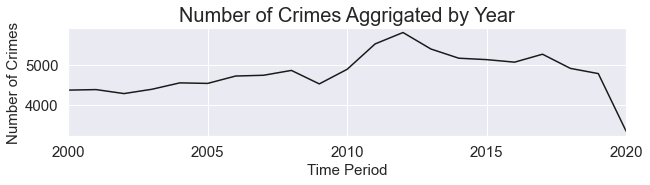

In [6]:
ts_plot()

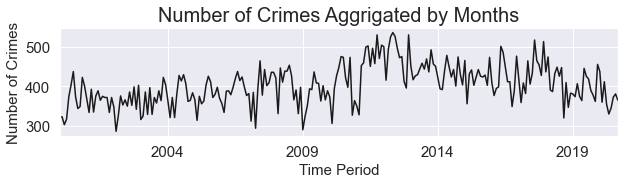

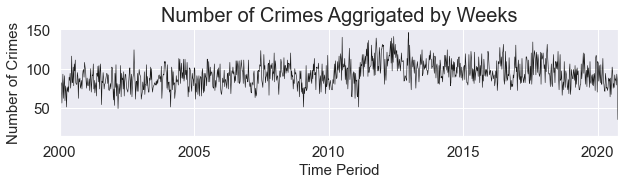

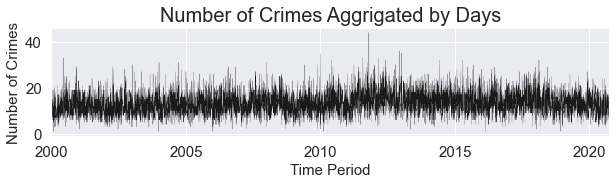

In [7]:
ts_plot('Months')
ts_plot('Weeks', lwd=0.6)
ts_plot('Days', lwd=0.2)

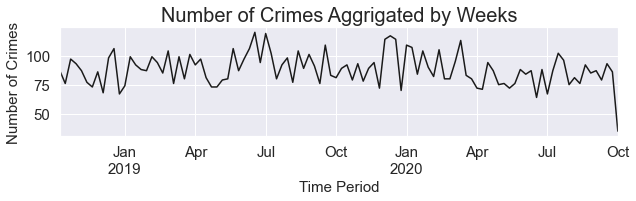

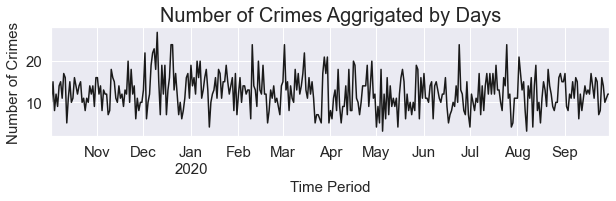

In [8]:
# Looking into smaller time window 

ts_plot('Weeks', last=104)
ts_plot('Days', last=365)

# Time Series Model 

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

### Removing Trend: I of AR-I-MA

In [10]:
def ts_jointplot(by='Year', last=0, dif=False):
    
    data, pre = by_select(by, last, dif)
    
    grid = sns.jointplot(x=data.index, y=data['Tot_Inc'], 
                         ec='k', fc='none', s=50, linewidth=0.9,
                         marginal_kws={'bins':23, 'kde':True, 
                                       'color':'steelblue', 
                                       'alpha':1})
    
    grid.set_axis_labels('Date', pre + 'Number of Crimes per ' + by, 
                         fontsize=15)
    plt.show()

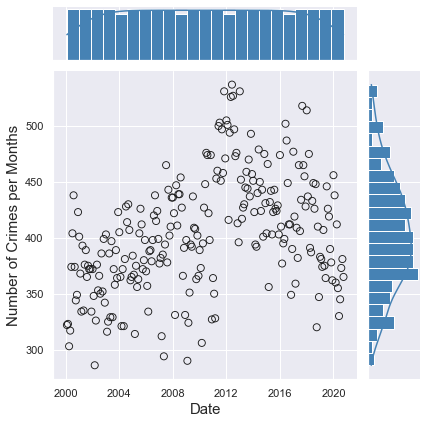

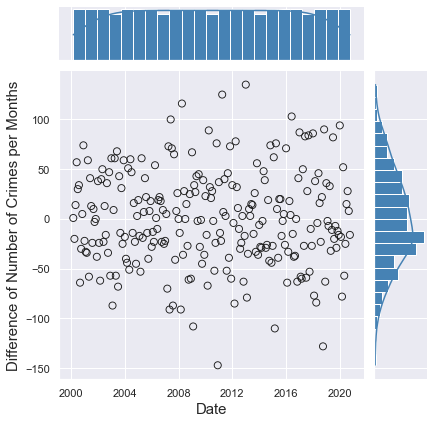

In [11]:
ts_jointplot(by='Months')
ts_jointplot(by='Months', dif=True)

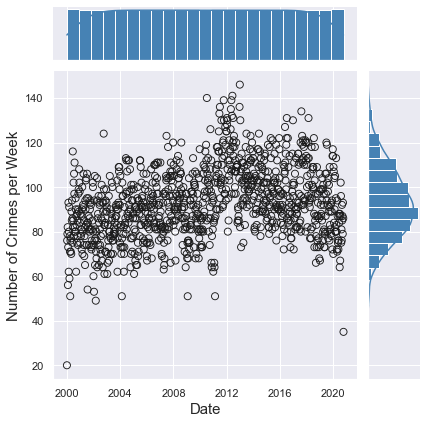

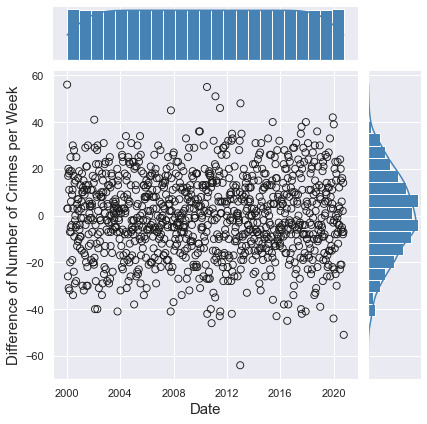

In [12]:
ts_jointplot(by='Week')
ts_jointplot(by='Week', dif=True)

### Order of AR & MA 

In [13]:
def plot_ACF(by='Year', last=0, dif=False, part=False):
    
    data, pre = by_select(by, last, dif)
    
    with mpl.rc_context():
        mpl.rc('figure', figsize=(10, 2))
        
        if part==True:
            plot_pacf(data, use_vlines=True, color='k')
            name, abr = ['Partial ', 'P']
        else:
            plot_acf(data, use_vlines=True, color='k')
            name, abr = ['', '']
        
        plt.title(name + 'Autocorrelation of ' + pre + \
                  'of Number of Crimes', fontsize=20)
        plt.ylabel(abr + 'ACF', fontsize=15)
        plt.xlabel('Number of Lag', fontsize=15)
    plt.show()

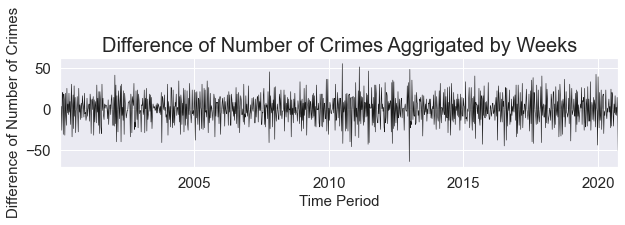

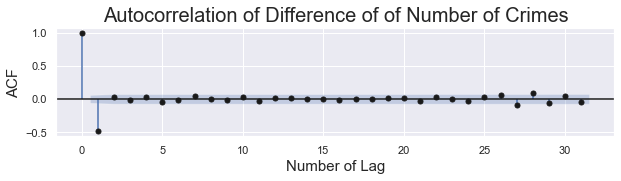

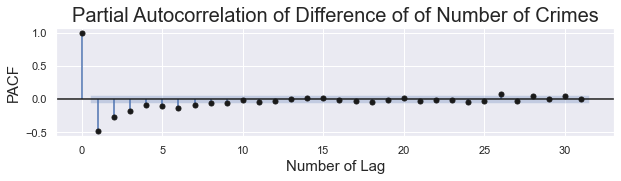

In [14]:
ts_plot(by='Weeks', dif=True, lwd=0.6)
plot_ACF(by='Week', dif=True)
plot_ACF(by='Week', dif=True, part=True)

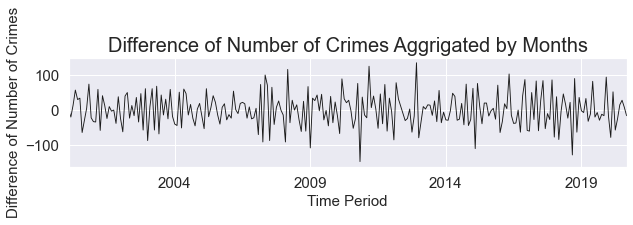

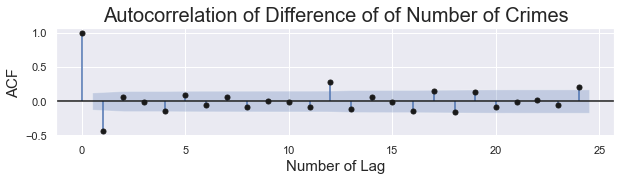

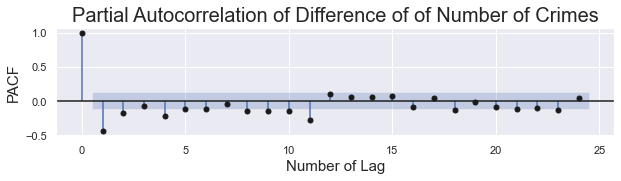

In [15]:
ts_plot(by='Months', dif=True, lwd=0.9)
plot_ACF(by='Months', dif=True)
plot_ACF(by='Months', dif=True, part=True)

### Hyperparameter Tuning: Fit SARIMA model with annual periodicity

In [16]:
ts_w = ts.resample('W').sum()
ts_m = ts.resample('M').sum()
ts_w.head()

,Tot_Inc
Date,
2000-01-02,20
2000-01-09,76
2000-01-16,79
2000-01-23,82
2000-01-30,56


In [17]:
auto_arma = arma_order_select_ic(ts_w)
print('BIC: \n', auto_arma['bic'], 
      '\n\nBIC min order: \t', auto_arma['bic_min_order'])

BIC: 
              0            1            2
0  9081.558702  8977.223250  8918.211735
1  8912.736094  8757.080317  8763.574944
2  8834.077304  8763.485938  8761.645795
3  8808.350518  8766.127483  8768.362489
4  8799.601547  8770.381026  8774.868345 

BIC min order: 	 (1, 1)


In [18]:
auto_arima = arma_order_select_ic(ts_w.diff()[1:])
print('BIC: \n', auto_arima['bic'], 
      '\n\nBIC min order: \t', auto_arima['bic_min_order'])

BIC: 
              0            1            2
0  9277.497705  8755.003946  8759.674698
1  8982.110667  8759.134207  8749.247992
2  8893.284917  8757.191947  8756.026052
3  8856.027590  8759.123856  8761.924206
4  8851.075498  8763.647031  8770.234481 

BIC min order: 	 (1, 2)


In [19]:
# ARIMA(1, 1, 2) has smaller BIC than ARMA(1, 1). So we choose ARIMA(1, 1, 2) and ignore seasonality for now. 

In [20]:
model = ARIMA(ts_w, order=(1, 1, 2))
week_model = model.fit()
week_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Tot_Inc   No. Observations:                 1083
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -4357.155
Method:                       css-mle   S.D. of innovations             13.510
Date:                Mon, 12 Oct 2020   AIC                           8724.311
Time:                        10:22:26   BIC                           8749.248
Sample:                    01-09-2000   HQIC                          8733.752
                         - 10-04-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0069      0.021      0.336      0.737      -0.033       0.047
ar.L1.D.Tot_Inc     0.8727      0.052     16.748      0.000       0.771       0.975
ma.L1.D.Tot_Inc    -1.6915      0.068    -24.993      0.000      -1.824      -1.559
ma.L2.D.Tot_Inc     0.6976      0.065     10.813      0.000       0.571       0.824
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1458           +0.0000j            1.1458            0.0000
MA.1            1.0218           +0.0000j            1.0218            0.0000
MA.2            1.4029           +0.0000j            1.4029            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
auto_arma = arma_order_select_ic(ts_m)
print('BIC: \n', auto_arma['bic'], 
      '\n\nBIC min order: \t', auto_arma['bic_min_order'])

BIC: 
              0            1            2
0  2678.454121  2627.840106  2600.322474
1  2588.078028  2570.535955  2575.315141
2  2572.296380  2572.407789  2581.495759
3  2576.580779  2572.540341  2577.999517
4  2582.038912  2585.931292  2575.723711 

BIC min order: 	 (1, 1)


C:\Python\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [22]:
auto_arima = arma_order_select_ic(ts_m.diff()[1:])
print('BIC: \n', auto_arima['bic'], 
      '\n\nBIC min order: \t', auto_arima['bic_min_order'])

BIC: 
              0            1            2
0  2631.912306  2563.539703  2563.006326
1  2583.599640  2559.161140  2560.919005
2  2581.701230  2558.822688  2564.295587
3  2585.882644  2564.232669  2568.517660
4  2579.171876  2565.940555  2570.817344 

BIC min order: 	 (2, 1)


In [23]:
model = ARIMA(ts_m, order=(0, 1, 1))
months_model = model.fit()
months_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Tot_Inc   No. Observations:                  248
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1273.500
Method:                       css-mle   S.D. of innovations             41.049
Date:                Mon, 12 Oct 2020   AIC                           2552.999
Time:                        10:22:50   BIC                           2563.540
Sample:                    02-29-2000   HQIC                          2557.243
                         - 09-30-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1401      0.786      0.178      0.858      -1.400       1.680
ma.L1.D.Tot_Inc    -0.7016      0.081     -8.695      0.000      -0.860      -0.543
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4254           +0.0000j            1.4254            0.0000
-----------------------------------------------------------------------------
"""

### Model Perfermance 

In [24]:
def pred_plot(model_name, by='Month', last=0, dif=False, title='',
              start=0, end=-1, alpha=1, ylim=None):
    
    data, pre = by_select(by, last, dif)
    pred = model_name.predict(typ='levels', end=end)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(data[start:], color='olive', linewidth=0.5, alpha=alpha)
    ax.plot(pred[start:], color='k', linewidth=1.5, alpha=1)
    ax.set_ylim(ylim)

    obs = mpl.patches.Patch(color='olive', label='Observed')
    pds = mpl.patches.Patch(color='k', label='Predicted')
    plt.legend(handles=[obs, pds], loc=4)

    plt.title('Prediction by {} for {}ly Data'.format(str(title), by), 
              fontsize=20)
    plt.ylabel('Number of Crimes', fontsize=15)
    plt.xlabel('Year', fontsize=15)
    plt.show()

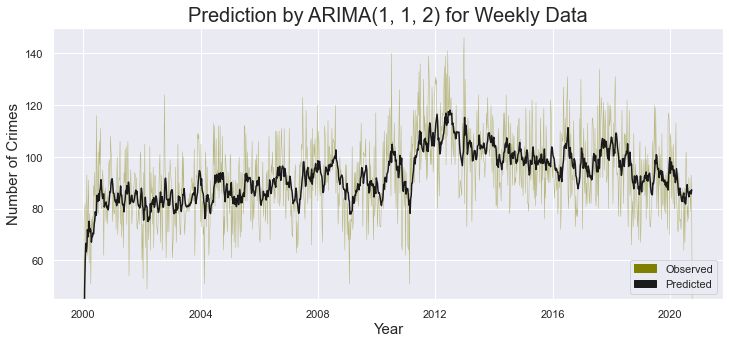

In [25]:
pred_plot(week_model, by='Week', title='ARIMA(1, 1, 2)', 
          alpha=0.5, ylim=[45, 150])

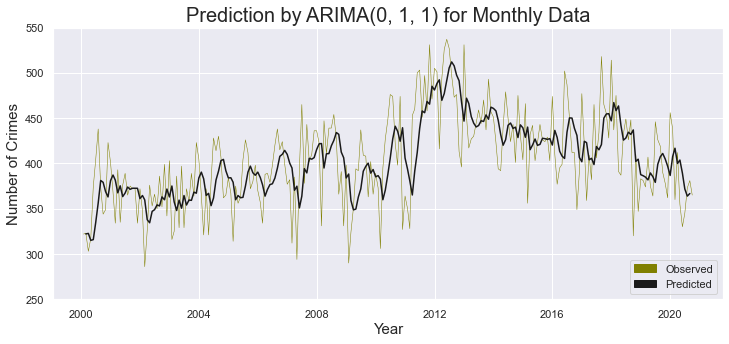

In [26]:
pred_plot(months_model, title='ARIMA(0, 1, 1)', alpha=1, ylim=[250, 550])

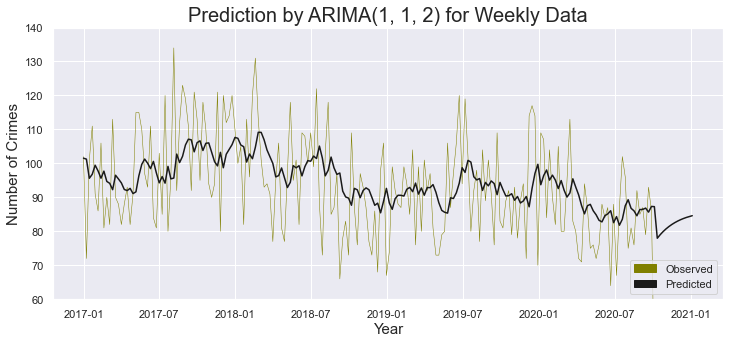

In [27]:
pred_plot(week_model, by='Week', title='ARIMA(1, 1, 2)', alpha=1, 
         start='2017-01-01', end='2021-01-01', ylim=[60, 140])

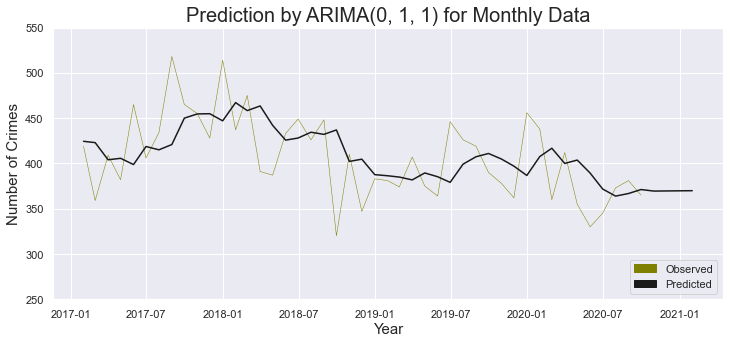

In [28]:
pred_plot(months_model, title='ARIMA(0, 1, 1)', alpha=1, 
         start='2017-01-01', end='2021-01-01', ylim=[250, 550])

### Model Evaluation 

In [29]:
def model_performance(model_name, by='', title='', lwd=1):
    
    resids = model_name.resid
    ljung = acorr_ljungbox(resids, return_df=False, lags=20)

    fig = plt.figure(figsize=(12, 8))

    ax1 = fig.add_subplot(221)
    resids.plot(color='k', linewidth=lwd)
    ax1.set_title('Residue Over the Time', fontsize=15)
    ax1.set(xlabel='Time', ylabel='Residue')

    ax2 = fig.add_subplot(222)
    sm.graphics.qqplot(resids, line ='s', marker='o', color='k',
                       mfc='none', ax=ax2)
    ax2.set_title('Q-Q Plot', fontsize=15)
    ax2.set(xlabel='Theoretical Quantiles', ylabel='Sample Quantiles')

    ax3 = fig.add_subplot(223)
    plot_acf(resids, color='k', ax=ax3)
    ax3.set_title('Autocorrelation of Residue', fontsize=15)
    ax3.set(xlabel='Number of Lags', ylabel='ACF')

    ax4 = fig.add_subplot(224)
    plt.plot(ljung[1], 'ko', mfc='none')
    ax4.set_title('p-Value of Ljung-Box Statistics', fontsize=15)
    ax4.set(xlabel='Number of Lags', ylabel='p-Value')

    fig.subplots_adjust(wspace = 0.3, hspace=0.4)
    fig.suptitle('Performance of {} on {}ly Data'.format(title, by), 
                 fontsize=20)
    plt.show()

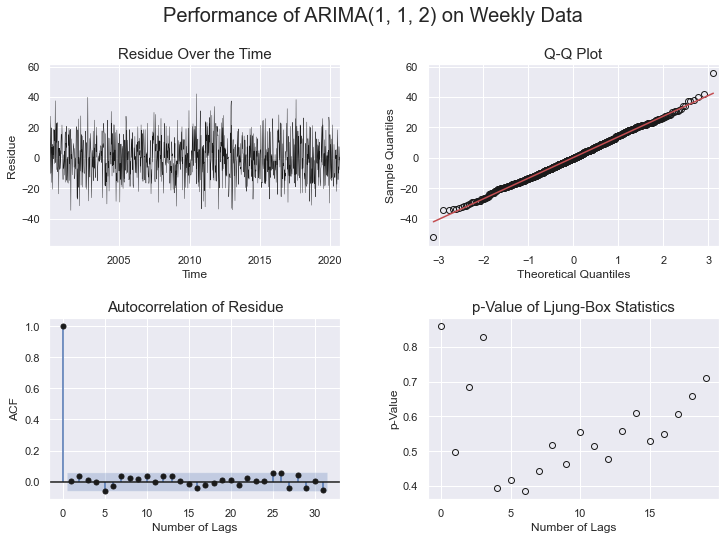

In [30]:
model_performance(week_model, by='Week', title='ARIMA(1, 1, 2)', lwd=0.4)

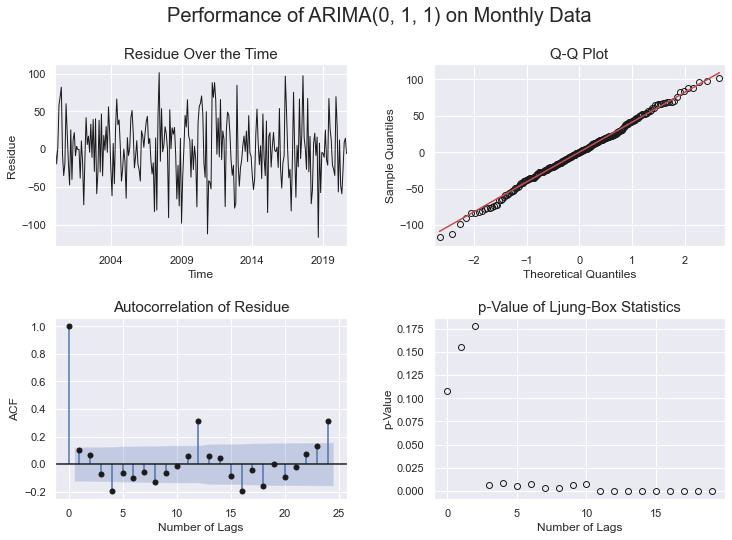

In [31]:
model_performance(months_model, by='Month', title='ARIMA(0, 1, 1)')

### SARIMAX model 

- There seems to be no auto sarima
- There are 7 parameters p, d, q, P, D, Q, s. They can be anything. May be write a for loop to find the optimal value. 

In [32]:
import warnings
warnings.filterwarnings("ignore")

min_bic = 100000
pm, dm, qm, Pm, Dm, Qm = [0, 0, 0, 0, 0, 0]
for p in range(2):
    for d in range(2):
        for q in range(2):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        model = SARIMAX(ts_m, 
                                        order=(p, d, q), 
                                        seasonal_order=(P, D, Q, 12))
                        result = model.fit()
                        bic_i = result.bic
                        if bic_i < min_bic:
                            min_bic = bic_i
                            pm, dm, qm, Pm, Dm, Qm = [p, d, q, P, D, Q]
                            print('{}\t{}\t{}\t{}\t{}\t{}\t{}'\
                                  .format(p, d, q, P, D, Q, result.bic))

0	0	0	0	0	0	3704.623867474596
0	0	0	0	0	1	3447.614479537539
0	0	0	0	1	0	2539.4579785164638
0	0	0	0	1	1	2485.895092082822
0	0	1	0	1	1	2455.2537479236876
0	1	1	0	1	1	2393.0143749553617


In [33]:
print(' Minimum BIC:\t\t', min_bic, 
      '\n Order of minimum BIC:\t', [pm, dm, qm, Pm, Dm, Qm])

 Minimum BIC:		 2393.0143749553617 
 Order of minimum BIC:	 [0, 1, 1, 0, 1, 1]


In [35]:
model = SARIMAX(ts_m, order=(0, 1, 1), seasonal_order=(0, 2, 1, 12))
sarima_model = model.fit()
sarima_model.bic

2427.6929487204807

In [36]:
model = SARIMAX(ts_m, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
sarima_model = model.fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Tot_Inc   No. Observations:                  249
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1188.311
Date:                            Mon, 12 Oct 2020   AIC                           2382.623
Time:                                    10:24:14   BIC                           2393.014
Sample:                                01-31-2000   HQIC                          2386.812
                                     - 09-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6819      0.047    -14.492      0.000      -0.774      -0.590
ma.S.L12      -0.8849      0.060    -14.760      0.000      -1.002      -0.767
sigma2      1277.6397    115.244     11.086      0.000    1051.766    1503.513
===================================================================================
Ljung-Box (Q):                       37.88   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.57   Prob(JB):                         0.50
Heteroskedasticity (H):               1.64   Skew:                            -0.17
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

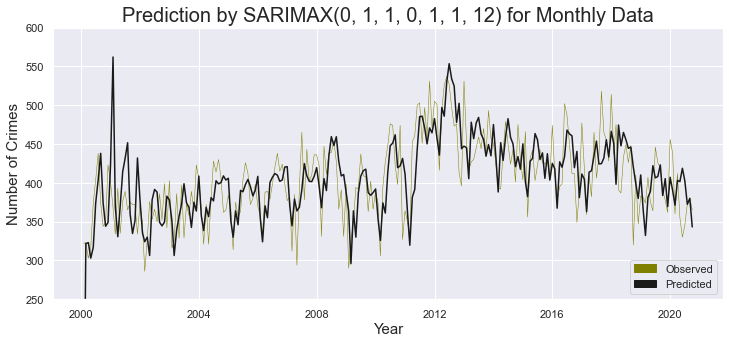

In [37]:
pred_plot(sarima_model, title='SARIMAX(0, 1, 1, 0, 1, 1, 12)', 
          alpha=1, ylim=[250, 600])

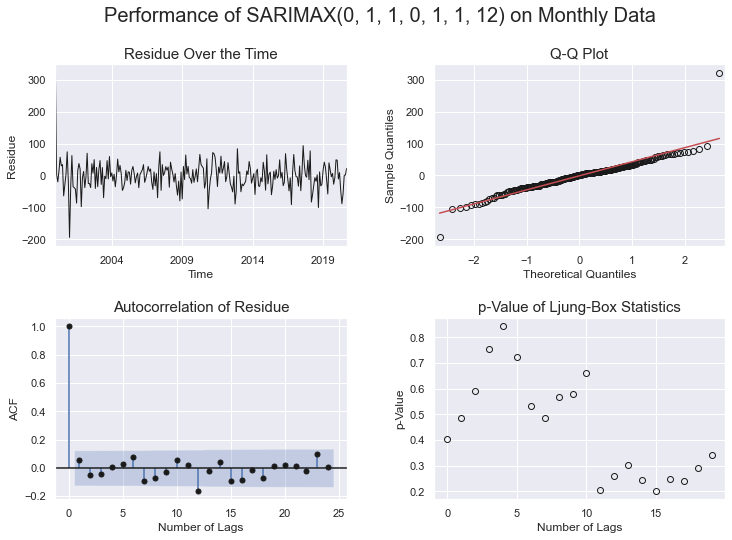

In [38]:
model_performance(sarima_model, by='Month', title='SARIMAX(0, 1, 1, 0, 1, 1, 12)')